In [66]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from sklearn.model_selection import train_test_split

#Importing models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

In [67]:
#Reading data files
train = pd.read_csv(r'D:\Data Science\Black Friday sales\train.csv')
test = pd.read_csv(r'D:\Data Science\Black Friday sales\test.csv')
sample = pd.read_csv(r'D:\Data Science\Black Friday sales\sample.csv')

In [68]:
# train.drop('Product_Category_3', axis = 1, inplace = True)
# test.drop('Product_Category_3', axis = 1, inplace = True)

In [69]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


---

In [70]:
id = 'User_ID'
p_id = 'Product_ID'
target = 'Purchase'

In [71]:
#Creating Helper Functions
def join_df(train, test):
    df = pd.concat([train, test], axis = 0, sort = False)
    return df

def split_df(df):
    train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:]
    features = [col for col in train.columns if col not in [target]]
    return train_proc, test_proc, features

In [72]:
df = join_df(train, test)

In [73]:
df.tail()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
233594,1006036,P00118942,F,26-35,15,B,4+,1,8,NaN,NaN,NaN
233595,1006036,P00254642,F,26-35,15,B,4+,1,5,8.0,NaN,NaN
233596,1006036,P00031842,F,26-35,15,B,4+,1,1,5.0,12.0,NaN
233597,1006037,P00124742,F,46-50,1,C,4+,0,10,16.0,NaN,NaN
233598,1006039,P00316642,F,46-50,0,B,4+,1,4,5.0,NaN,NaN


In [74]:
df.fillna(999, inplace = True)

In [75]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,999.0,999.0,8370.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,999.0,999.0,1422.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,999.0,1057.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,999.0,999.0,7969.0


In [76]:
df[['User_ID','Product_ID','Gender', 'Age', 'City_Category', 'Product_Category_1', 'Product_Category_2', 'Stay_In_Current_City_Years']] = df[['User_ID','Product_ID', 'Gender', 'Age', 'City_Category', 'Product_Category_1', 'Product_Category_2', 'Stay_In_Current_City_Years']].apply(le.fit_transform)

In [77]:
df

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,684,0,0,10,0,2,0,2,17,999.0,8370.0
1,0,2406,0,0,10,0,2,0,0,4,14.0,15200.0
2,0,868,0,0,10,0,2,0,11,17,999.0,1422.0
3,0,844,0,0,10,0,2,0,11,12,999.0,1057.0
4,1,2769,1,6,16,2,4,0,7,17,999.0,7969.0
5,2,1857,1,2,15,0,3,0,0,0,999.0,15227.0
6,3,1771,1,4,7,1,2,1,0,6,17.0,19215.0
7,3,3364,1,4,7,1,2,1,0,13,999.0,15854.0
8,3,3649,1,4,7,1,2,1,0,14,999.0,15686.0
9,4,2665,1,2,20,0,1,1,7,17,999.0,7871.0


In [78]:
train_proc, test_proc, features = split_df(df)

---

### Various Models

1.Linear Regression

2.Decision Tree

3.RandomForest

4.LGBM

5.CatBoost

6.XGBoost

In [79]:
#Splitting data into train and test
X_train, X_val, y_train, y_val = train_test_split(train_proc[features], train_proc[target], test_size = 0.2, random_state = 0)

In [80]:
# lr = LinearRegression()

# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val,y_preds)))
# # 4649.24

In [81]:
# dt = DecisionTreeRegressor(random_state = 0)

# dt.fit(X_train, y_train)
# y_preds = dt.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val, y_preds)))
# # 3761.29

In [82]:
# rf = RandomForestRegressor(random_state = 0)

# rf.fit(X_train, y_train)
# y_preds = rf.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val, y_preds)))
# # 2725.60

In [83]:
# %%time
# lgb = LGBMRegressor(random_state = 0)

# lgb.fit(X_train, y_train)
# y_preds = lgb.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val, y_preds)))
# # 2758.14

In [84]:
# cat = CatBoostRegressor(random_state = 0, cat_features=['User_ID','Product_ID','Gender', 'Occupation', 'Product_Category_1'], )

# cat.fit(X_train, y_train)
# y_preds = cat.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val, y_preds)))
# #2617

In [85]:
# %%time
# xgb = XGBRegressor(random_state = 0)

# xgb.fit(X_train, y_train)
# y_preds = xgb.predict(X_val)
# print('Mean Squared Error is : ', np.sqrt(mean_squared_error(y_val, y_preds)))
# #2658

In [86]:
# preds = lgb.predict(test_proc[features])

# sample[target] = preds
# sample.to_csv(r'D:\Data Science\Black Friday sales\lgb.csv')

---

### Cross Validation

In [87]:
def cross_val(train, test, features, clf):
    preds_df = pd.DataFrame()
    oofs = np.zeros(len(train))
    preds = np.zeros(len(test))
    
    folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
    
    for index, (trn_idx, val_idx) in enumerate(folds.split(train)):
        print()
        print(f'*******************Fold {index+1}*******************')
        print()
        X_trn, y_trn = train[features].iloc[trn_idx], train[target].iloc[trn_idx]
        X_val, y_val = train[features].iloc[val_idx], train[target].iloc[val_idx]
        
        X_test = test[features]
        
        _ = clf.fit(X_trn, y_trn)
        
        val_preds = clf.predict(X_val)
        test_preds = clf.predict(X_test)
        
        oofs[val_idx] = val_preds
        preds_df[str(index+1)] = test_preds
        
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        print('Mean Squared Error is : ',rmse)
        
    total_score = np.sqrt(mean_squared_error(train[target], oofs))
    print('Total score :',total_score)
    preds_df['mean'] = preds_df.apply(lambda x:x.mean(), axis = 1)
    preds = preds_df['mean']
    return oofs, preds

In [88]:
#cat_oofs, cat_preds = cross_val(train_proc, test_proc, features, CatBoostRegressor(random_state = 0, cat_features=['User_ID','Product_ID','Gender', 'Occupation', 'Product_Category_1']))
#cat = 2646.4907

In [89]:
# cat_oofs, cat_preds = cross_val(train_proc, test_proc, features, XGBRegressor(random_state = 0))
# #cat = 2646.4907
# #lgb without prod 3 = 2776
# #lgb with prod 3 = 2765

In [90]:
# sample[target] = xgb_preds
# sample.to_csv(r'D:\Data Science\Black Friday sales\xgb_preds_mean_5_cv.csv')

---

## Feature Engineering

In [119]:
df2 = join_df(train, test)

In [120]:
df2['Product_Category_2'].fillna(df2['Product_Category_2'].mode()[0], inplace = True)
df2['Product_Category_3'].fillna(df2['Product_Category_3'].mode()[0], inplace = True)

In [121]:
all_features = [col for col in train.columns if col not in [target,'City_Category', 'Occupation']]
df2[all_features] = df2[all_features].apply(le.fit_transform)

In [122]:
df2.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,684,0,0,10,A,2,0,2,6,12,8370.0
1,0,2406,0,0,10,A,2,0,0,4,10,15200.0
2,0,868,0,0,10,A,2,0,11,6,12,1422.0
3,0,844,0,0,10,A,2,0,11,12,12,1057.0
4,1,2769,1,6,16,C,4,0,7,6,12,7969.0


---

In [123]:
# Interaction Features
# Two features that are related are combined to form a single feature
# Eg. Combining day and month

In [124]:
# Grouping Features
# One feature that is created using another feature based on the third feature
# Mean value of age on a particular day of a customer

---

In [125]:
occ_dict = df2['Occupation'].value_counts().to_dict()
df2['Occ_freq'] = df2['Occupation'].apply(lambda x: occ_dict[x])
df2['Prod_1_freq'] = df2.groupby('Product_Category_1')['Age'].transform('count')
df2['Prod_2_freq'] = df2.groupby('Product_Category_2')['Age'].transform('count')

#Creating feature of how many products were bought from product_category_1
df2['Total_prods_from_prod_1_by_same_user'] = df2.groupby('User_ID')['Product_Category_1'].transform('count')

famous_prod_1 = [5,1,8]
df2['famous_1'] = df2['Product_Category_1'].apply(lambda x : 1 if x in famous_prod_1 else 0)

famous_prod_2 = [8,14,2,16,15]
df2['famous_2'] = df2['Product_Category_2'].apply(lambda x : 1 if x in famous_prod_2 else 0)

cheap_1_list = [4,5,8,11,12,13,18,19,20]
df2['cheap_1'] = df2['Product_Category_1'].apply(lambda x : 1 if x in cheap_1_list else 0)

cheap_2_list = [7,9,12,14,17]
df2['cheap_2'] = df2['Product_Category_2'].apply(lambda x : 1 if x in cheap_2_list else 0)

df2['median_user'] = df2.groupby('User_ID')['Purchase'].transform('median')
df2['median_prod'] = df2.groupby('Product_ID')['Purchase'].transform('median')

df2['std'] = df2.groupby('User_ID')['Purchase'].transform('std')

exp_prod_1 = [9,10,14,16]
df2['exp_prod'] = df2['Product_Category_1'].apply(lambda x : 1 if x in exp_prod_1 else 0)

In [126]:
fam_occ_list = [3,5,6,8,9,10,11,13,15,18,19]
df2['fam_occ'] = df2['Occupation'].apply(lambda x : 1 if x in fam_occ_list else 0)

In [127]:
df2['is_working'] = df2['Age'].apply(lambda x : 1 if x in [1,2] else 0)

df2['high_buyers'] = df2['Occupation'].apply(lambda x : 2 if x in [8,12,15,17] else 0 if x in [1,2,9,18,19,20] else 1)

---

In [129]:
df2 = pd.get_dummies(df2, columns = ['City_Category', 'Occupation'], drop_first = True)

In [130]:
df2.head()

,User_ID,Product_ID,Gender,Age,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,0,684,0,0,2,0,2,6,12,8370.0,...,0,0,0,0,0,0,0,0,0,0
1,0,2406,0,0,2,0,0,4,10,15200.0,...,0,0,0,0,0,0,0,0,0,0
2,0,868,0,0,2,0,11,6,12,1422.0,...,0,0,0,0,0,0,0,0,0,0
3,0,844,0,0,2,0,11,12,12,1057.0,...,0,0,0,0,0,0,0,0,0,0
4,1,2769,1,6,4,0,7,6,12,7969.0,...,0,0,0,0,0,1,0,0,0,0


## Feature selection

In [132]:
# xgb_f = ['Gender','Marital_Status','mean_price','mean_price_','Occ_freq','fam_occ','is_working','Purchase', 'cheap_2', 'famous_2']

# features_2 = [col for col in df2.columns if col not in xgb_f]
# features_2

In [133]:
lgb_f = ['fam_occ','mean_price','mean_price_','Marital_Status','exp_prod','is_working','famous_2','Purchase', 'cheap_2']
features_2 = [col for col in df2.columns if col not in lgb_f]
features_2

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Stay_In_Current_City_Years',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Occ_freq',
 'Prod_1_freq',
 'Prod_2_freq',
 'Total_prods_from_prod_1_by_same_user',
 'famous_1',
 'cheap_1',
 'median_user',
 'median_prod',
 'std',
 'high_buyers',
 'City_Category_B',
 'City_Category_C',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20']

In [134]:
# cat_f = ['mean_price','mean_price_','fam_occ','is_working','famous_2', 'cheap_2','Gender','Purchase']
# features_2 = [col for col in df2.columns if col not in cat_f]
# features_2

In [135]:
df2.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Stay_In_Current_City_Years',
       'Marital_Status', 'Product_Category_1', 'Product_Category_2',
       'Product_Category_3', 'Purchase', 'Occ_freq', 'Prod_1_freq',
       'Prod_2_freq', 'Total_prods_from_prod_1_by_same_user', 'famous_1',
       'famous_2', 'cheap_1', 'cheap_2', 'median_user', 'median_prod', 'std',
       'exp_prod', 'fam_occ', 'is_working', 'high_buyers', 'City_Category_B',
       'City_Category_C', 'Occupation_1', 'Occupation_2', 'Occupation_3',
       'Occupation_4', 'Occupation_5', 'Occupation_6', 'Occupation_7',
       'Occupation_8', 'Occupation_9', 'Occupation_10', 'Occupation_11',
       'Occupation_12', 'Occupation_13', 'Occupation_14', 'Occupation_15',
       'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19',
       'Occupation_20'],
      dtype='object')

In [136]:
train_proc_2, test_proc_2, features = split_df(df2)

---

In [137]:
# sample[target] = lgb_pre
# sample.to_csv(r'D:\Data Science\Black Friday sales\cat_median_std_user.csv')

In [139]:
model = LGBMRegressor(random_state = 0)
# # model = XGBRegressor(random_state = 0)
# # # model = CatBoostRegressor(random_state = 0)

lgb_oo, lgb_pre = cross_val(train_proc_2, test_proc_2, features_2, model)

# # #lgb with selected features = 2495.5437

# # #rf with selected features = 

# # #xgb with selected features = 2465.6194

# # #cat with selected features = 2431.4695


*******************Fold 1*******************

Mean Squared Error is :  2485.240755593314

*******************Fold 2*******************

Mean Squared Error is :  2491.942905696714

*******************Fold 3*******************

Mean Squared Error is :  2491.4154504020935

*******************Fold 4*******************

Mean Squared Error is :  2508.0995987281885

*******************Fold 5*******************

Mean Squared Error is :  2502.202845673704
Total score : 2495.793814888186


### Feature importance

In [140]:
temp = model.feature_importances_

In [141]:
temp = pd.DataFrame({'imp' : model.feature_importances_})

In [142]:
for i,v in enumerate(features_2):
    print(i, v)

0 User_ID
1 Product_ID
2 Gender
3 Age
4 Stay_In_Current_City_Years
5 Product_Category_1
6 Product_Category_2
7 Product_Category_3
8 Occ_freq
9 Prod_1_freq
10 Prod_2_freq
11 Total_prods_from_prod_1_by_same_user
12 famous_1
13 cheap_1
14 median_user
15 median_prod
16 std
17 high_buyers
18 City_Category_B
19 City_Category_C
20 Occupation_1
21 Occupation_2
22 Occupation_3
23 Occupation_4
24 Occupation_5
25 Occupation_6
26 Occupation_7
27 Occupation_8
28 Occupation_9
29 Occupation_10
30 Occupation_11
31 Occupation_12
32 Occupation_13
33 Occupation_14
34 Occupation_15
35 Occupation_16
36 Occupation_17
37 Occupation_18
38 Occupation_19
39 Occupation_20


---

In [143]:
# # CatBoost
# temp.plot.bar()

In [144]:
# # XGB
# temp.plot.bar()

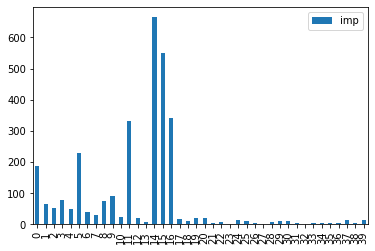

In [145]:
# LGBM
temp.plot.bar()

---

## Hyperparameter Optimization (Tuning)

In [146]:
X_trn,X_val,y_trn,y_val = train_test_split(train_proc_2.drop('Purchase', axis = 1), train_proc['Purchase'], test_size = 0.2, random_state = 0)

---

## XGB Tuning

In [147]:
# %%time
# def create_model_1(trial):
#     max_depth = trial.suggest_int('max_depth',2,30)
#     n_estimators = trial.suggest_int('n_estimators',1,500)
#     learning_rate = trial.suggest_uniform('learning_rate',0.1,1)
#     colsample_bytree = trial.suggest_uniform('colsample_bytree',0.1,0.9)
#     reg_alpha = trial.suggest_int('reg_alpha',1,10)
#     reg_lambda = trial.suggest_int('reg_lambda',1,10)
    
#     model = XGBRegressor(learning_rate=learning_rate,
#                         n_estimators = n_estimators,
#                         max_depth = max_depth,
#                         colsample_bytree = colsample_bytree,
#                         random_state = 0,
#                         n_jobs = -1)
#     return model

# sampler = TPESampler(seed = 0)

# def objective(trial):
#     model = create_model_1(trial)
#     model.fit(X_trn,y_trn)
#     preds = model.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val,preds))
#     return score

# study = optuna.create_study(direction = 'minimize', sampler = sampler)
# study.optimize(objective, n_trials = 30)

# xgb_params = study.best_params
# xgb_params['random_state'] = 0
# xgb = XGBRegressor(**xgb_params)
# xgb.fit(X_trn, y_trn)
# preds = xgb.predict(X_val)
# print('Optimized XGBR RMSE', np.sqrt(mean_squared_error(y_val,preds)))

In [148]:
# xgb_params ={'max_depth': 11,
#  'n_estimators': 344,
#  'learning_rate': 0.10609000563003972,
#  'colsample_bytree': 0.24277204893228554,
#  'reg_alpha': 6,
#  'random_state': 0}

In [149]:
# xgb_oo, xgb_pre = cross_val(train_proc_2, test_proc_2, features_2, XGBRegressor(**xgb_params))
# #2430.9916

In [150]:
# sample[target] = xgb_pre
# sample.to_csv(r'D:\Data Science\Black Friday sales\xgb_hyperparameter_tuned.csv')

---

## Catboost Tuning

In [151]:
# %%time
# def create_model_2(trial):
#     max_depth = trial.suggest_int("max_depth", 1, 16)
#     n_estimators = trial.suggest_int("n_estimators", 500, 1500)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
#     rsm = trial.suggest_uniform('rsm', 0.1, 0.99)
#     #num_leaves = trial.suggest_int("num_leaves", 2, 5000)
#     #min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
#     reg_lambda = trial.suggest_int("reg_lambda", 1, 1000)
    
#     model = CatBoostRegressor(
#         learning_rate = learning_rate, 
#         n_estimators = n_estimators, 
#         max_depth = max_depth,
#         rsm = rsm,
#         reg_lambda = reg_lambda,
#         #num_leaves=num_leaves, 
#         #min_child_samples=min_child_samples,
#         random_state=0,
#         verbose = False
#     )
#     return model

# sampler = TPESampler(seed=0)

# def objective(trial):
#     model = create_model_2(trial)
#     model.fit(X_trn, y_trn)
#     preds = model.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val,preds))
#     return score

# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# cat_params = study.best_params
# cat_params['random_state'] = 0
# cat = CatBoostRegressor(**cat_params, verbose = False)
# cat.fit(X_trn, y_trn)
# preds = cat.predict(X_val)
# print('Optimized Catboost RMSE', np.sqrt(mean_squared_error(y_val, preds)))

In [152]:
# cat_params = {'max_depth': 14,
#  'n_estimators': 838,
#  'learning_rate': 0.33307386672352757,
#  'rsm': 0.40207837117001777,
#  'reg_lambda': 570,
#  'random_state': 0}
features_2

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'Stay_In_Current_City_Years',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3',
 'Occ_freq',
 'Prod_1_freq',
 'Prod_2_freq',
 'Total_prods_from_prod_1_by_same_user',
 'famous_1',
 'cheap_1',
 'median_user',
 'median_prod',
 'std',
 'high_buyers',
 'City_Category_B',
 'City_Category_C',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'Occupation_5',
 'Occupation_6',
 'Occupation_7',
 'Occupation_8',
 'Occupation_9',
 'Occupation_10',
 'Occupation_11',
 'Occupation_12',
 'Occupation_13',
 'Occupation_14',
 'Occupation_15',
 'Occupation_16',
 'Occupation_17',
 'Occupation_18',
 'Occupation_19',
 'Occupation_20']

In [165]:
cat_oo, cat_pre = cross_val(train_proc_2, test_proc_2, features_2, CatBoostRegressor(**cat_params, cat_features = ['User_ID', 'Product_ID', 'Product_Category_1', 'cheap_1','Gender','Age','Stay_In_Current_City_Years','Product_Category_2','Prod_1_freq', 'famous_1','high_buyers','Prod_2_freq','Product_Category_3']))
# 2421.9217 with cat features
# 2435.4120 without cat features

In [ ]:
# sample[target] = cat_pre
# sample.to_csv(r'D:\Data Science\Black Friday sales\cat_hyperparameter_tuned.csv')

---

## LGBM Tuning

In [154]:
# %%time
# def create_model_3(trial):
#     max_depth = trial.suggest_int("max_depth", 2, 30)
#     n_estimators = trial.suggest_int("n_estimators", 1, 2000)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
#     num_leaves = trial.suggest_int("num_leaves", 2, 5000) 
#     colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9),
#     min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
#     reg_alpha = trial.suggest_uniform("reg_alpha", 0.1, 10)
#     reg_lambda = trial.suggest_uniform("reg_lambda", 0.1, 10)
    
#     model = LGBMRegressor(
#         learning_rate = learning_rate, 
#         n_estimators = n_estimators, 
#         max_depth = max_depth,
#         num_leaves = num_leaves,
#         colsample_bytree = colsample_bytree,
#         min_child_samples = min_child_samples,
#         n_jobs = -1,
#         random_state = 0
#     )
#     return model

# sampler = TPESampler(seed=0)
# def objective(trial):
#     model = create_model_3(trial)
#     model.fit(X_trn, y_trn)
#     preds = model.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val,preds))
#     return score

# study = optuna.create_study(direction = "minimize", sampler = sampler)
# study.optimize(objective, n_trials = 50)

# lgb_params = study.best_params
# lgb_params['random_state'] = 0
# lgb = LGBMRegressor(**lgb_params)
# lgb.fit(X_trn, y_trn)
# preds = lgb.predict(X_val)
# print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

In [155]:
# lgb_params = {'max_depth': 10,
#  'n_estimators': 828,
#  'learning_rate': 0.10739487109912883,
#  'num_leaves': 1560,
#  'colsample_bytree': 0.7835832769721667,
#  'min_child_samples': 177,
#  'reg_alpha': 1,
#  'reg_lambda': 1,
#  'random_state': 0}

In [156]:
# lgb_oo, lgb_pre = cross_val(train_proc_2, test_proc_2, features_2, LGBMRegressor(**lgb_params))
# # 2429.7959

In [157]:
# sample[target] = lgb_pre
# sample.to_csv(r'D:\Data Science\Black Friday sales\lgb2hyperparameter_tuning.csv')

---

## RandomForest Tuning

In [158]:
# %%time
# def create_model_4(trial):
#     max_depth = trial.suggest_int('max_depth',2, 20)
#     n_estimators = trial.suggest_int('n_estimators',2, 2000)
#     min_samples_split = trial.suggest_int('min_samples_split',2, 200)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf',2, 100)
    
    
#     model = RandomForestRegressor(
#         max_depth = max_depth,
#         n_estimators = n_estimators,
#         min_samples_split = min_samples_split,
#         min_samples_leaf = min_samples_leaf,
#         n_jobs = -1,
#         random_state = 0
#     )
#     return model

# sampler = TPESampler(seed = 0)
# def objective(trial):
#     model = create_model_4(trial)
#     model.fit(X_trn, y_trn)
#     preds = model.predict(X_val)
#     score = np.sqrt(mean_squared_error(y_val,preds))
#     return score

# study = optuna.create_study(direction = "minimize", sampler = sampler)
# study.optimize(objective, n_trials=50)


In [ ]:
# rf_params = study.best_params
# rf_params['random_state'] = 0
# rf = RandomForestRegressor(**rf_params)
# rf.fit(X_trn, y_trn)
# preds = rf.predict(X_val)
# print('Optimized LightGBM roc_auc_score', np.sqrt(mean_squared_error(y_val, preds)))

In [162]:
# rf_params = {'max_depth': 18, 'n_estimators': 1400, 'min_samples_split': 23, 'min_samples_leaf': 2}

---

## Stacking

### Level 0

In [161]:
train_new = pd.DataFrame()
test_new = pd.DataFrame()

train_new['id'] = train['User_ID']
train_new['xgb'] = xgb_oo
train_new['lgb'] = lgb_oo
train_new['cat'] = cat_oo
train_new[target] = train[target]

test_new['id'] = test['User_ID']
test_new['xgb'] = xgb_pre
test_new['lgb'] = lgb_pre
test_new['cat'] = cat_pre

features_new = [col for col in train_new.columns if col not in ['id',target]]

In [162]:
xgb_oofs_new, xgb_preds_new = cross_val(train_new, test_new, features_new, XGBRegressor(**xgb_params))
# 2416.3381


*******************Fold 1*******************

Mean Squared Error is :  2407.0209325516944

*******************Fold 2*******************

Mean Squared Error is :  2408.5626699090744

*******************Fold 3*******************

Mean Squared Error is :  2413.0770812921037

*******************Fold 4*******************

Mean Squared Error is :  2431.376675516931

*******************Fold 5*******************

Mean Squared Error is :  2421.5682434680884
Total score : 2416.3381099604144


In [163]:
lgb_oofs_new, lgb_preds_new = cross_val(train_new, test_new, features_new, LGBMRegressor(**lgb_params))
# 2426.4285


*******************Fold 1*******************

Mean Squared Error is :  2417.251300473922

*******************Fold 2*******************

Mean Squared Error is :  2418.668098969855

*******************Fold 3*******************

Mean Squared Error is :  2421.7723724473094

*******************Fold 4*******************

Mean Squared Error is :  2443.358757781905

*******************Fold 5*******************

Mean Squared Error is :  2430.994780462553
Total score : 2426.4285415977643


In [164]:
cat_oofs_new, cat_preds_new = cross_val(train_new, test_new, features_new, CatBoostRegressor(**cat_params))
# 2407.6498 


*******************Fold 1*******************

0:	learn: 4138.5017481	total: 36.2ms	remaining: 30.3s
1:	learn: 3355.2029482	total: 105ms	remaining: 43.7s
2:	learn: 2905.3593725	total: 194ms	remaining: 54s
3:	learn: 2674.3366905	total: 259ms	remaining: 54s
4:	learn: 2674.3357762	total: 286ms	remaining: 47.6s
5:	learn: 2674.3353690	total: 316ms	remaining: 43.8s
6:	learn: 2559.2698209	total: 367ms	remaining: 43.6s
7:	learn: 2559.2698144	total: 400ms	remaining: 41.5s
8:	learn: 2495.3235983	total: 479ms	remaining: 44.1s
9:	learn: 2463.8655556	total: 549ms	remaining: 45.5s
10:	learn: 2450.1683112	total: 593ms	remaining: 44.6s
11:	learn: 2443.6090343	total: 629ms	remaining: 43.3s
12:	learn: 2431.5518811	total: 744ms	remaining: 47.2s
13:	learn: 2431.5512860	total: 771ms	remaining: 45.4s
14:	learn: 2425.2037042	total: 976ms	remaining: 53.5s
15:	learn: 2423.7986859	total: 1.02s	remaining: 52.6s
16:	learn: 2423.0697864	total: 1.06s	remaining: 51.3s
17:	learn: 2423.0697428	total: 1.09s	remaining: 

151:	learn: 2406.1118372	total: 10.4s	remaining: 46.8s
152:	learn: 2406.1118367	total: 10.4s	remaining: 46.6s
153:	learn: 2406.0941075	total: 10.5s	remaining: 46.6s
154:	learn: 2406.0279045	total: 10.6s	remaining: 46.8s
155:	learn: 2406.0146032	total: 10.7s	remaining: 46.6s
156:	learn: 2405.9785519	total: 10.7s	remaining: 46.5s
157:	learn: 2405.9514275	total: 10.8s	remaining: 46.4s
158:	learn: 2405.9368544	total: 10.8s	remaining: 46.2s
159:	learn: 2405.9307120	total: 10.9s	remaining: 46s
160:	learn: 2405.9307120	total: 10.9s	remaining: 45.8s
161:	learn: 2405.8678684	total: 11s	remaining: 45.7s
162:	learn: 2405.8485043	total: 11s	remaining: 45.6s
163:	learn: 2405.8484998	total: 11s	remaining: 45.4s
164:	learn: 2405.8231129	total: 11.1s	remaining: 45.2s
165:	learn: 2405.7886581	total: 11.2s	remaining: 45.1s
166:	learn: 2405.7770214	total: 11.2s	remaining: 45s
167:	learn: 2405.7678238	total: 11.2s	remaining: 44.8s
168:	learn: 2405.7122130	total: 11.3s	remaining: 44.9s
169:	learn: 2405.712

302:	learn: 2403.6176134	total: 19.6s	remaining: 34.7s
303:	learn: 2403.6064027	total: 19.7s	remaining: 34.6s
304:	learn: 2403.6059707	total: 19.7s	remaining: 34.5s
305:	learn: 2403.6058318	total: 19.8s	remaining: 34.3s
306:	learn: 2403.5545801	total: 19.8s	remaining: 34.3s
307:	learn: 2403.5148321	total: 20s	remaining: 34.4s
308:	learn: 2403.5051651	total: 20s	remaining: 34.3s
309:	learn: 2403.4159851	total: 20.1s	remaining: 34.3s
310:	learn: 2403.4158702	total: 20.2s	remaining: 34.2s
311:	learn: 2403.4153553	total: 20.2s	remaining: 34s
312:	learn: 2403.4142788	total: 20.2s	remaining: 33.9s
313:	learn: 2403.3783458	total: 20.3s	remaining: 33.8s
314:	learn: 2403.3781513	total: 20.3s	remaining: 33.7s
315:	learn: 2403.3187119	total: 20.4s	remaining: 33.7s
316:	learn: 2403.2359845	total: 20.6s	remaining: 33.8s
317:	learn: 2403.2290565	total: 20.6s	remaining: 33.7s
318:	learn: 2403.2290562	total: 20.6s	remaining: 33.6s
319:	learn: 2403.1071351	total: 20.9s	remaining: 33.9s
320:	learn: 2403

453:	learn: 2401.5410071	total: 29.9s	remaining: 25.3s
454:	learn: 2401.5372054	total: 29.9s	remaining: 25.2s
455:	learn: 2401.5309338	total: 29.9s	remaining: 25.1s
456:	learn: 2401.5302537	total: 30s	remaining: 25s
457:	learn: 2401.5301332	total: 30s	remaining: 24.9s
458:	learn: 2401.5301332	total: 30s	remaining: 24.8s
459:	learn: 2401.5298411	total: 30.1s	remaining: 24.7s
460:	learn: 2401.5222879	total: 30.1s	remaining: 24.6s
461:	learn: 2401.5074116	total: 30.2s	remaining: 24.6s
462:	learn: 2401.5074114	total: 30.2s	remaining: 24.5s
463:	learn: 2401.5074114	total: 30.2s	remaining: 24.4s
464:	learn: 2401.5029100	total: 30.3s	remaining: 24.3s
465:	learn: 2401.5027555	total: 30.3s	remaining: 24.2s
466:	learn: 2401.5027553	total: 30.3s	remaining: 24.1s
467:	learn: 2401.4917608	total: 30.4s	remaining: 24s
468:	learn: 2401.4825298	total: 30.4s	remaining: 23.9s
469:	learn: 2401.4754244	total: 30.4s	remaining: 23.8s
470:	learn: 2401.4754244	total: 30.5s	remaining: 23.7s
471:	learn: 2401.443

604:	learn: 2400.3658339	total: 38.6s	remaining: 14.9s
605:	learn: 2400.3524100	total: 38.7s	remaining: 14.8s
606:	learn: 2400.3232420	total: 38.8s	remaining: 14.8s
607:	learn: 2400.2762665	total: 38.8s	remaining: 14.7s
608:	learn: 2400.2762157	total: 38.9s	remaining: 14.6s
609:	learn: 2400.2762154	total: 38.9s	remaining: 14.5s
610:	learn: 2400.2666167	total: 38.9s	remaining: 14.5s
611:	learn: 2400.2342409	total: 39s	remaining: 14.4s
612:	learn: 2400.2342408	total: 39s	remaining: 14.3s
613:	learn: 2400.2342407	total: 39.1s	remaining: 14.2s
614:	learn: 2400.2232054	total: 39.1s	remaining: 14.2s
615:	learn: 2400.2232042	total: 39.1s	remaining: 14.1s
616:	learn: 2400.2156865	total: 39.2s	remaining: 14s
617:	learn: 2400.2132293	total: 39.2s	remaining: 14s
618:	learn: 2400.2132291	total: 39.2s	remaining: 13.9s
619:	learn: 2400.2064884	total: 39.3s	remaining: 13.8s
620:	learn: 2400.2064482	total: 39.4s	remaining: 13.8s
621:	learn: 2400.1267454	total: 39.6s	remaining: 13.8s
622:	learn: 2400.1

754:	learn: 2399.0244209	total: 48.5s	remaining: 5.33s
755:	learn: 2399.0208301	total: 48.5s	remaining: 5.26s
756:	learn: 2399.0206526	total: 48.6s	remaining: 5.2s
757:	learn: 2399.0206525	total: 48.6s	remaining: 5.13s
758:	learn: 2399.0100247	total: 48.7s	remaining: 5.07s
759:	learn: 2399.0042314	total: 48.8s	remaining: 5s
760:	learn: 2399.0041312	total: 48.8s	remaining: 4.94s
761:	learn: 2398.9967011	total: 48.8s	remaining: 4.87s
762:	learn: 2398.9936375	total: 48.9s	remaining: 4.8s
763:	learn: 2398.9936375	total: 48.9s	remaining: 4.74s
764:	learn: 2398.9899440	total: 48.9s	remaining: 4.67s
765:	learn: 2398.9899438	total: 49s	remaining: 4.6s
766:	learn: 2398.9888748	total: 49s	remaining: 4.54s
767:	learn: 2398.9188760	total: 49.5s	remaining: 4.51s
768:	learn: 2398.9074615	total: 49.6s	remaining: 4.45s
769:	learn: 2398.8482122	total: 49.6s	remaining: 4.38s
770:	learn: 2398.8482121	total: 49.7s	remaining: 4.32s
771:	learn: 2398.8443618	total: 49.7s	remaining: 4.25s
772:	learn: 2398.832

66:	learn: 2409.1791643	total: 4.44s	remaining: 51.1s
67:	learn: 2409.1701349	total: 4.47s	remaining: 50.7s
68:	learn: 2408.9437726	total: 4.84s	remaining: 54s
69:	learn: 2408.8912320	total: 4.89s	remaining: 53.7s
70:	learn: 2408.8912279	total: 4.93s	remaining: 53.2s
71:	learn: 2408.6409430	total: 5.02s	remaining: 53.4s
72:	learn: 2408.6409403	total: 5.04s	remaining: 52.9s
73:	learn: 2408.5954430	total: 5.09s	remaining: 52.5s
74:	learn: 2408.4485440	total: 5.16s	remaining: 52.5s
75:	learn: 2408.4450441	total: 5.2s	remaining: 52.1s
76:	learn: 2408.4401149	total: 5.23s	remaining: 51.7s
77:	learn: 2408.3289789	total: 5.31s	remaining: 51.8s
78:	learn: 2408.1521990	total: 5.38s	remaining: 51.7s
79:	learn: 2408.0970253	total: 5.42s	remaining: 51.4s
80:	learn: 2408.0342466	total: 5.46s	remaining: 51.1s
81:	learn: 2407.9244107	total: 5.51s	remaining: 50.9s
82:	learn: 2407.9203775	total: 5.54s	remaining: 50.4s
83:	learn: 2407.8316111	total: 5.64s	remaining: 50.6s
84:	learn: 2407.7903208	total: 

217:	learn: 2403.8424827	total: 14.5s	remaining: 41.3s
218:	learn: 2403.8399578	total: 14.6s	remaining: 41.2s
219:	learn: 2403.8376929	total: 14.6s	remaining: 41s
220:	learn: 2403.7699189	total: 14.9s	remaining: 41.6s
221:	learn: 2403.7695540	total: 14.9s	remaining: 41.4s
222:	learn: 2403.7388737	total: 15s	remaining: 41.4s
223:	learn: 2403.7388736	total: 15s	remaining: 41.2s
224:	learn: 2403.7332913	total: 15.1s	remaining: 41.1s
225:	learn: 2403.7049923	total: 15.1s	remaining: 41s
226:	learn: 2403.6888663	total: 15.2s	remaining: 40.9s
227:	learn: 2403.6828672	total: 15.2s	remaining: 40.7s
228:	learn: 2403.6212597	total: 15.3s	remaining: 40.7s
229:	learn: 2403.6075676	total: 15.4s	remaining: 40.6s
230:	learn: 2403.5989433	total: 15.4s	remaining: 40.5s
231:	learn: 2403.5558204	total: 15.6s	remaining: 40.7s
232:	learn: 2403.5427409	total: 15.6s	remaining: 40.6s
233:	learn: 2403.5326575	total: 15.7s	remaining: 40.5s
234:	learn: 2403.5326574	total: 15.7s	remaining: 40.3s
235:	learn: 2403.5

368:	learn: 2401.7281802	total: 23.4s	remaining: 29.7s
369:	learn: 2401.7267211	total: 23.4s	remaining: 29.7s
370:	learn: 2401.7267210	total: 23.5s	remaining: 29.5s
371:	learn: 2401.7267210	total: 23.5s	remaining: 29.4s
372:	learn: 2401.7124903	total: 23.6s	remaining: 29.4s
373:	learn: 2401.7109271	total: 23.6s	remaining: 29.3s
374:	learn: 2401.7101678	total: 23.6s	remaining: 29.2s
375:	learn: 2401.6915541	total: 23.7s	remaining: 29.1s
376:	learn: 2401.6618235	total: 23.8s	remaining: 29.1s
377:	learn: 2401.6593163	total: 23.8s	remaining: 29s
378:	learn: 2401.5854816	total: 24.3s	remaining: 29.5s
379:	learn: 2401.4991526	total: 24.8s	remaining: 29.9s
380:	learn: 2401.4924748	total: 24.8s	remaining: 29.8s
381:	learn: 2401.4921964	total: 24.9s	remaining: 29.7s
382:	learn: 2401.4873589	total: 24.9s	remaining: 29.6s
383:	learn: 2401.4571394	total: 25s	remaining: 29.6s
384:	learn: 2401.4258785	total: 25.2s	remaining: 29.6s
385:	learn: 2401.4258760	total: 25.2s	remaining: 29.5s
386:	learn: 24

519:	learn: 2400.2632325	total: 32.8s	remaining: 20s
520:	learn: 2400.2550134	total: 32.8s	remaining: 20s
521:	learn: 2400.2436405	total: 32.9s	remaining: 19.9s
522:	learn: 2400.2199490	total: 33s	remaining: 19.9s
523:	learn: 2400.1951789	total: 33.1s	remaining: 19.8s
524:	learn: 2400.1951781	total: 33.1s	remaining: 19.7s
525:	learn: 2400.1942963	total: 33.1s	remaining: 19.6s
526:	learn: 2400.1768742	total: 33.2s	remaining: 19.6s
527:	learn: 2400.1740081	total: 33.2s	remaining: 19.5s
528:	learn: 2400.1740081	total: 33.2s	remaining: 19.4s
529:	learn: 2400.1706310	total: 33.3s	remaining: 19.3s
530:	learn: 2400.1316409	total: 33.4s	remaining: 19.3s
531:	learn: 2400.1315222	total: 33.4s	remaining: 19.2s
532:	learn: 2400.1315220	total: 33.4s	remaining: 19.1s
533:	learn: 2400.1111909	total: 33.5s	remaining: 19.1s
534:	learn: 2400.1111035	total: 33.5s	remaining: 19s
535:	learn: 2400.1111035	total: 33.5s	remaining: 18.9s
536:	learn: 2400.1111035	total: 33.6s	remaining: 18.8s
537:	learn: 2400.1

670:	learn: 2398.7468447	total: 41.8s	remaining: 10.4s
671:	learn: 2398.7371583	total: 41.8s	remaining: 10.3s
672:	learn: 2398.7262640	total: 41.9s	remaining: 10.3s
673:	learn: 2398.7262640	total: 41.9s	remaining: 10.2s
674:	learn: 2398.7262639	total: 41.9s	remaining: 10.1s
675:	learn: 2398.7262008	total: 42s	remaining: 10.1s
676:	learn: 2398.7253790	total: 42s	remaining: 9.99s
677:	learn: 2398.7233100	total: 42s	remaining: 9.92s
678:	learn: 2398.7233099	total: 42.1s	remaining: 9.85s
679:	learn: 2398.6832984	total: 42.2s	remaining: 9.8s
680:	learn: 2398.6832983	total: 42.2s	remaining: 9.73s
681:	learn: 2398.6829774	total: 42.2s	remaining: 9.66s
682:	learn: 2398.6829773	total: 42.3s	remaining: 9.59s
683:	learn: 2398.6829281	total: 42.3s	remaining: 9.52s
684:	learn: 2398.6829281	total: 42.3s	remaining: 9.46s
685:	learn: 2398.6821218	total: 42.4s	remaining: 9.39s
686:	learn: 2398.6814486	total: 42.4s	remaining: 9.32s
687:	learn: 2398.6763014	total: 42.5s	remaining: 9.26s
688:	learn: 2398.

820:	learn: 2397.5159976	total: 51.6s	remaining: 1.07s
821:	learn: 2397.5159968	total: 51.7s	remaining: 1s
822:	learn: 2397.5135993	total: 51.7s	remaining: 942ms
823:	learn: 2397.5131956	total: 51.8s	remaining: 879ms
824:	learn: 2397.5114383	total: 51.8s	remaining: 816ms
825:	learn: 2397.5110996	total: 51.8s	remaining: 753ms
826:	learn: 2397.5089566	total: 51.9s	remaining: 690ms
827:	learn: 2397.5089149	total: 51.9s	remaining: 627ms
828:	learn: 2397.5088692	total: 51.9s	remaining: 564ms
829:	learn: 2397.5088692	total: 52s	remaining: 501ms
830:	learn: 2397.4520662	total: 52.5s	remaining: 443ms
831:	learn: 2397.4520306	total: 52.6s	remaining: 379ms
832:	learn: 2397.3434653	total: 53.2s	remaining: 319ms
833:	learn: 2397.3434653	total: 53.2s	remaining: 255ms
834:	learn: 2397.3413205	total: 53.3s	remaining: 191ms
835:	learn: 2397.3367288	total: 53.3s	remaining: 128ms
836:	learn: 2397.3360001	total: 53.3s	remaining: 63.7ms
837:	learn: 2397.2776623	total: 53.4s	remaining: 0us
Mean Squared Err

133:	learn: 2405.8081685	total: 9.2s	remaining: 48.3s
134:	learn: 2405.8081683	total: 9.22s	remaining: 48s
135:	learn: 2405.8081682	total: 9.26s	remaining: 47.8s
136:	learn: 2405.8081682	total: 9.28s	remaining: 47.5s
137:	learn: 2405.7872728	total: 9.36s	remaining: 47.5s
138:	learn: 2405.7244660	total: 9.43s	remaining: 47.4s
139:	learn: 2405.7139648	total: 9.47s	remaining: 47.2s
140:	learn: 2405.7124362	total: 9.5s	remaining: 47s
141:	learn: 2405.6990226	total: 9.55s	remaining: 46.8s
142:	learn: 2405.6899484	total: 9.6s	remaining: 46.7s
143:	learn: 2405.6899482	total: 9.63s	remaining: 46.4s
144:	learn: 2405.6741230	total: 9.68s	remaining: 46.3s
145:	learn: 2405.6741230	total: 9.71s	remaining: 46s
146:	learn: 2405.6731255	total: 9.74s	remaining: 45.8s
147:	learn: 2405.6731255	total: 9.78s	remaining: 45.6s
148:	learn: 2405.6731255	total: 9.81s	remaining: 45.3s
149:	learn: 2405.5334068	total: 9.91s	remaining: 45.5s
150:	learn: 2405.5334062	total: 9.94s	remaining: 45.2s
151:	learn: 2405.52

283:	learn: 2402.9885502	total: 18.6s	remaining: 36.4s
284:	learn: 2402.9858002	total: 18.7s	remaining: 36.3s
285:	learn: 2402.9855038	total: 18.7s	remaining: 36.1s
286:	learn: 2402.9855037	total: 18.7s	remaining: 36s
287:	learn: 2402.9831833	total: 18.8s	remaining: 35.9s
288:	learn: 2402.9831833	total: 18.8s	remaining: 35.8s
289:	learn: 2402.9110011	total: 18.9s	remaining: 35.7s
290:	learn: 2402.9092608	total: 18.9s	remaining: 35.6s
291:	learn: 2402.9092603	total: 18.9s	remaining: 35.4s
292:	learn: 2402.9014528	total: 19s	remaining: 35.3s
293:	learn: 2402.9014517	total: 19s	remaining: 35.2s
294:	learn: 2402.8905114	total: 19.1s	remaining: 35.1s
295:	learn: 2402.8891172	total: 19.1s	remaining: 35s
296:	learn: 2402.8442602	total: 19.2s	remaining: 35s
297:	learn: 2402.8442585	total: 19.2s	remaining: 34.8s
298:	learn: 2402.8372386	total: 19.2s	remaining: 34.7s
299:	learn: 2402.8174268	total: 19.3s	remaining: 34.6s
300:	learn: 2402.8174260	total: 19.3s	remaining: 34.5s
301:	learn: 2402.814

434:	learn: 2401.0749830	total: 29.1s	remaining: 26.9s
435:	learn: 2401.0725309	total: 29.1s	remaining: 26.8s
436:	learn: 2401.0725307	total: 29.1s	remaining: 26.7s
437:	learn: 2401.0684774	total: 29.1s	remaining: 26.6s
438:	learn: 2401.0684773	total: 29.2s	remaining: 26.5s
439:	learn: 2401.0560554	total: 29.2s	remaining: 26.4s
440:	learn: 2401.0560164	total: 29.3s	remaining: 26.3s
441:	learn: 2401.0558927	total: 29.3s	remaining: 26.3s
442:	learn: 2401.0542320	total: 29.3s	remaining: 26.2s
443:	learn: 2401.0542319	total: 29.4s	remaining: 26.1s
444:	learn: 2401.0521946	total: 29.4s	remaining: 26s
445:	learn: 2401.0423297	total: 29.5s	remaining: 25.9s
446:	learn: 2401.0353623	total: 29.5s	remaining: 25.8s
447:	learn: 2401.0245700	total: 29.5s	remaining: 25.7s
448:	learn: 2401.0175233	total: 29.6s	remaining: 25.6s
449:	learn: 2401.0079555	total: 29.6s	remaining: 25.6s
450:	learn: 2401.0054268	total: 29.7s	remaining: 25.5s
451:	learn: 2401.0038176	total: 29.7s	remaining: 25.4s
452:	learn: 

584:	learn: 2399.6997781	total: 37.5s	remaining: 16.2s
585:	learn: 2399.6997775	total: 37.6s	remaining: 16.1s
586:	learn: 2399.6716277	total: 37.6s	remaining: 16.1s
587:	learn: 2399.6653658	total: 37.7s	remaining: 16s
588:	learn: 2399.6653657	total: 37.7s	remaining: 15.9s
589:	learn: 2399.6604786	total: 37.7s	remaining: 15.9s
590:	learn: 2399.6458893	total: 37.8s	remaining: 15.8s
591:	learn: 2399.6420018	total: 37.8s	remaining: 15.7s
592:	learn: 2399.6420018	total: 37.8s	remaining: 15.6s
593:	learn: 2399.6419166	total: 37.9s	remaining: 15.6s
594:	learn: 2399.6418448	total: 37.9s	remaining: 15.5s
595:	learn: 2399.6409843	total: 37.9s	remaining: 15.4s
596:	learn: 2399.6376170	total: 38s	remaining: 15.3s
597:	learn: 2399.6376170	total: 38s	remaining: 15.3s
598:	learn: 2399.6376170	total: 38s	remaining: 15.2s
599:	learn: 2399.6281826	total: 38.1s	remaining: 15.1s
600:	learn: 2399.6280061	total: 38.1s	remaining: 15s
601:	learn: 2399.5956808	total: 38.3s	remaining: 15s
602:	learn: 2399.59140

734:	learn: 2398.4636271	total: 47.2s	remaining: 6.61s
735:	learn: 2398.4627817	total: 47.2s	remaining: 6.54s
736:	learn: 2398.4392856	total: 47.7s	remaining: 6.53s
737:	learn: 2398.4392854	total: 47.7s	remaining: 6.46s
738:	learn: 2398.3994318	total: 47.8s	remaining: 6.4s
739:	learn: 2398.3994315	total: 47.8s	remaining: 6.33s
740:	learn: 2398.3930525	total: 47.9s	remaining: 6.27s
741:	learn: 2398.3930517	total: 47.9s	remaining: 6.2s
742:	learn: 2398.3928660	total: 47.9s	remaining: 6.13s
743:	learn: 2398.3835307	total: 48s	remaining: 6.07s
744:	learn: 2398.3692566	total: 48.1s	remaining: 6s
745:	learn: 2398.3640529	total: 48.1s	remaining: 5.93s
746:	learn: 2398.3232454	total: 48.2s	remaining: 5.87s
747:	learn: 2398.2592830	total: 48.3s	remaining: 5.81s
748:	learn: 2398.2592064	total: 48.3s	remaining: 5.74s
749:	learn: 2398.2576291	total: 48.4s	remaining: 5.67s
750:	learn: 2398.2497673	total: 48.4s	remaining: 5.61s
751:	learn: 2398.2454433	total: 48.5s	remaining: 5.54s
752:	learn: 2398.

46:	learn: 2406.8710567	total: 3.05s	remaining: 51.4s
47:	learn: 2406.7603346	total: 3.1s	remaining: 51s
48:	learn: 2406.6679924	total: 3.14s	remaining: 50.5s
49:	learn: 2406.0845337	total: 3.66s	remaining: 57.7s
50:	learn: 2406.0522294	total: 3.7s	remaining: 57.1s
51:	learn: 2405.9050251	total: 3.75s	remaining: 56.7s
52:	learn: 2405.8871556	total: 3.78s	remaining: 56s
53:	learn: 2405.7007549	total: 3.84s	remaining: 55.8s
54:	learn: 2405.6923828	total: 3.87s	remaining: 55.1s
55:	learn: 2405.5352623	total: 3.94s	remaining: 55.1s
56:	learn: 2405.5352613	total: 3.98s	remaining: 54.5s
57:	learn: 2405.3885587	total: 4.04s	remaining: 54.3s
58:	learn: 2405.3885569	total: 4.07s	remaining: 53.8s
59:	learn: 2405.3809557	total: 4.11s	remaining: 53.2s
60:	learn: 2405.2599387	total: 4.2s	remaining: 53.5s
61:	learn: 2405.1695420	total: 4.24s	remaining: 53.1s
62:	learn: 2405.1695394	total: 4.27s	remaining: 52.5s
63:	learn: 2405.0939706	total: 4.31s	remaining: 52.1s
64:	learn: 2404.7993551	total: 4.39

197:	learn: 2399.3674001	total: 12.8s	remaining: 41.4s
198:	learn: 2399.3621342	total: 12.9s	remaining: 41.3s
199:	learn: 2399.2292672	total: 13s	remaining: 41.5s
200:	learn: 2399.2292650	total: 13s	remaining: 41.3s
201:	learn: 2399.1618449	total: 13.6s	remaining: 42.8s
202:	learn: 2399.1593951	total: 13.6s	remaining: 42.6s
203:	learn: 2399.1490202	total: 13.7s	remaining: 42.5s
204:	learn: 2399.1483638	total: 13.7s	remaining: 42.3s
205:	learn: 2399.1077001	total: 13.8s	remaining: 42.3s
206:	learn: 2399.1070939	total: 13.8s	remaining: 42.1s
207:	learn: 2399.0970630	total: 13.9s	remaining: 42s
208:	learn: 2399.0943699	total: 13.9s	remaining: 41.8s
209:	learn: 2399.0738933	total: 14s	remaining: 41.7s
210:	learn: 2399.0516224	total: 14s	remaining: 41.6s
211:	learn: 2399.0510938	total: 14s	remaining: 41.5s
212:	learn: 2398.9481063	total: 14.1s	remaining: 41.5s
213:	learn: 2398.9436536	total: 14.2s	remaining: 41.4s
214:	learn: 2398.9388037	total: 14.2s	remaining: 41.2s
215:	learn: 2398.91034

348:	learn: 2396.8651419	total: 22.5s	remaining: 31.5s
349:	learn: 2396.8649866	total: 22.5s	remaining: 31.4s
350:	learn: 2396.8649861	total: 22.5s	remaining: 31.2s
351:	learn: 2396.8649859	total: 22.5s	remaining: 31.1s
352:	learn: 2396.8627344	total: 22.6s	remaining: 31s
353:	learn: 2396.8483957	total: 22.6s	remaining: 31s
354:	learn: 2396.8482700	total: 22.7s	remaining: 30.9s
355:	learn: 2396.8479323	total: 22.7s	remaining: 30.8s
356:	learn: 2396.8479321	total: 22.7s	remaining: 30.6s
357:	learn: 2396.8479320	total: 22.8s	remaining: 30.5s
358:	learn: 2396.8186077	total: 22.9s	remaining: 30.5s
359:	learn: 2396.8182091	total: 22.9s	remaining: 30.4s
360:	learn: 2396.8012053	total: 22.9s	remaining: 30.3s
361:	learn: 2396.8012047	total: 23s	remaining: 30.2s
362:	learn: 2396.7783930	total: 23s	remaining: 30.1s
363:	learn: 2396.6948584	total: 23.2s	remaining: 30.2s
364:	learn: 2396.6882408	total: 23.2s	remaining: 30.1s
365:	learn: 2396.6791771	total: 23.3s	remaining: 30s
366:	learn: 2396.669

498:	learn: 2395.4804884	total: 31.5s	remaining: 21.4s
499:	learn: 2395.4173007	total: 31.6s	remaining: 21.4s
500:	learn: 2395.4172029	total: 31.7s	remaining: 21.3s
501:	learn: 2395.4172027	total: 31.7s	remaining: 21.2s
502:	learn: 2395.4130236	total: 31.7s	remaining: 21.1s
503:	learn: 2395.4126657	total: 31.8s	remaining: 21.1s
504:	learn: 2395.4075001	total: 31.8s	remaining: 21s
505:	learn: 2395.3556719	total: 32.3s	remaining: 21.2s
506:	learn: 2395.3397691	total: 32.4s	remaining: 21.1s
507:	learn: 2395.3375303	total: 32.4s	remaining: 21.1s
508:	learn: 2395.3373748	total: 32.5s	remaining: 21s
509:	learn: 2395.3372614	total: 32.5s	remaining: 20.9s
510:	learn: 2395.3292301	total: 32.5s	remaining: 20.8s
511:	learn: 2395.3026317	total: 32.6s	remaining: 20.7s
512:	learn: 2395.1684431	total: 33.1s	remaining: 21s
513:	learn: 2395.1645069	total: 33.1s	remaining: 20.9s
514:	learn: 2395.1606087	total: 33.2s	remaining: 20.8s
515:	learn: 2395.1606073	total: 33.2s	remaining: 20.7s
516:	learn: 2395

648:	learn: 2394.1038418	total: 40.3s	remaining: 11.7s
649:	learn: 2394.1030134	total: 40.4s	remaining: 11.7s
650:	learn: 2394.1029418	total: 40.4s	remaining: 11.6s
651:	learn: 2394.0998388	total: 40.5s	remaining: 11.5s
652:	learn: 2394.0996903	total: 40.5s	remaining: 11.5s
653:	learn: 2394.0973481	total: 40.5s	remaining: 11.4s
654:	learn: 2394.0919517	total: 40.6s	remaining: 11.3s
655:	learn: 2394.0808758	total: 40.6s	remaining: 11.3s
656:	learn: 2394.0740196	total: 40.7s	remaining: 11.2s
657:	learn: 2394.0699300	total: 40.7s	remaining: 11.1s
658:	learn: 2394.0643877	total: 40.8s	remaining: 11.1s
659:	learn: 2394.0592300	total: 40.8s	remaining: 11s
660:	learn: 2394.0592296	total: 40.8s	remaining: 10.9s
661:	learn: 2394.0592294	total: 40.9s	remaining: 10.9s
662:	learn: 2394.0542007	total: 40.9s	remaining: 10.8s
663:	learn: 2394.0450199	total: 41s	remaining: 10.8s
664:	learn: 2394.0398275	total: 41.1s	remaining: 10.7s
665:	learn: 2394.0396748	total: 41.1s	remaining: 10.6s
666:	learn: 23

798:	learn: 2392.8484028	total: 50.8s	remaining: 2.48s
799:	learn: 2392.8440800	total: 50.9s	remaining: 2.42s
800:	learn: 2392.7965124	total: 51.1s	remaining: 2.36s
801:	learn: 2392.7956858	total: 51.1s	remaining: 2.29s
802:	learn: 2392.7894020	total: 51.1s	remaining: 2.23s
803:	learn: 2392.7847892	total: 51.2s	remaining: 2.16s
804:	learn: 2392.7828288	total: 51.2s	remaining: 2.1s
805:	learn: 2392.7663248	total: 51.3s	remaining: 2.04s
806:	learn: 2392.7656643	total: 51.4s	remaining: 1.97s
807:	learn: 2392.7656643	total: 51.4s	remaining: 1.91s
808:	learn: 2392.7656643	total: 51.5s	remaining: 1.84s
809:	learn: 2392.7656512	total: 51.5s	remaining: 1.78s
810:	learn: 2392.7584830	total: 51.5s	remaining: 1.72s
811:	learn: 2392.7584830	total: 51.6s	remaining: 1.65s
812:	learn: 2392.7564787	total: 51.6s	remaining: 1.59s
813:	learn: 2392.7036212	total: 51.7s	remaining: 1.52s
814:	learn: 2392.6955868	total: 51.7s	remaining: 1.46s
815:	learn: 2392.6923934	total: 51.8s	remaining: 1.4s
816:	learn: 

111:	learn: 2404.0682838	total: 7.15s	remaining: 46.4s
112:	learn: 2404.0682830	total: 7.18s	remaining: 46.1s
113:	learn: 2403.9741149	total: 7.25s	remaining: 46.1s
114:	learn: 2403.8570490	total: 7.76s	remaining: 48.8s
115:	learn: 2403.7556048	total: 7.85s	remaining: 48.9s
116:	learn: 2403.7556035	total: 7.88s	remaining: 48.5s
117:	learn: 2403.7386670	total: 7.92s	remaining: 48.3s
118:	learn: 2403.6962202	total: 7.99s	remaining: 48.3s
119:	learn: 2403.5423724	total: 8.1s	remaining: 48.4s
120:	learn: 2403.5276611	total: 8.13s	remaining: 48.2s
121:	learn: 2403.5123633	total: 8.18s	remaining: 48s
122:	learn: 2403.4938768	total: 8.23s	remaining: 47.8s
123:	learn: 2403.4925449	total: 8.26s	remaining: 47.6s
124:	learn: 2403.4538152	total: 8.32s	remaining: 47.5s
125:	learn: 2403.3957046	total: 8.38s	remaining: 47.3s
126:	learn: 2403.3939327	total: 8.41s	remaining: 47.1s
127:	learn: 2403.1811973	total: 8.59s	remaining: 47.7s
128:	learn: 2403.1569490	total: 8.63s	remaining: 47.4s
129:	learn: 2

261:	learn: 2400.5839051	total: 16.9s	remaining: 37.1s
262:	learn: 2400.5839044	total: 16.9s	remaining: 36.9s
263:	learn: 2400.5836766	total: 16.9s	remaining: 36.8s
264:	learn: 2400.5405241	total: 17s	remaining: 36.7s
265:	learn: 2400.5399435	total: 17s	remaining: 36.6s
266:	learn: 2400.4876382	total: 17.1s	remaining: 36.6s
267:	learn: 2400.4835916	total: 17.2s	remaining: 36.5s
268:	learn: 2400.4830506	total: 17.2s	remaining: 36.4s
269:	learn: 2400.4778504	total: 17.2s	remaining: 36.2s
270:	learn: 2400.4555643	total: 17.3s	remaining: 36.2s
271:	learn: 2400.4516115	total: 17.3s	remaining: 36s
272:	learn: 2400.4326370	total: 17.4s	remaining: 36s
273:	learn: 2400.4326360	total: 17.4s	remaining: 35.8s
274:	learn: 2400.4326355	total: 17.4s	remaining: 35.7s
275:	learn: 2400.4246613	total: 17.5s	remaining: 35.6s
276:	learn: 2400.4213143	total: 17.5s	remaining: 35.5s
277:	learn: 2400.4197394	total: 17.5s	remaining: 35.3s
278:	learn: 2400.4193897	total: 17.6s	remaining: 35.2s
279:	learn: 2400.4

411:	learn: 2398.5452769	total: 26.6s	remaining: 27.5s
412:	learn: 2398.5452769	total: 26.6s	remaining: 27.4s
413:	learn: 2398.5451965	total: 26.6s	remaining: 27.3s
414:	learn: 2398.5451672	total: 26.6s	remaining: 27.2s
415:	learn: 2398.5332427	total: 26.7s	remaining: 27.1s
416:	learn: 2398.4926542	total: 26.8s	remaining: 27s
417:	learn: 2398.4916764	total: 26.8s	remaining: 26.9s
418:	learn: 2398.4872426	total: 26.8s	remaining: 26.8s
419:	learn: 2398.4848777	total: 26.9s	remaining: 26.8s
420:	learn: 2398.4636075	total: 26.9s	remaining: 26.7s
421:	learn: 2398.4634962	total: 27s	remaining: 26.6s
422:	learn: 2398.4466053	total: 27s	remaining: 26.5s
423:	learn: 2398.4465320	total: 27.1s	remaining: 26.4s
424:	learn: 2398.4431375	total: 27.1s	remaining: 26.3s
425:	learn: 2398.4431375	total: 27.1s	remaining: 26.2s
426:	learn: 2398.4428876	total: 27.2s	remaining: 26.1s
427:	learn: 2398.4402055	total: 27.2s	remaining: 26.1s
428:	learn: 2398.3771829	total: 27.7s	remaining: 26.4s
429:	learn: 2398

562:	learn: 2397.2767938	total: 34.9s	remaining: 17s
563:	learn: 2397.2509690	total: 34.9s	remaining: 17s
564:	learn: 2397.2508334	total: 35s	remaining: 16.9s
565:	learn: 2397.2507527	total: 35s	remaining: 16.8s
566:	learn: 2397.2507522	total: 35s	remaining: 16.7s
567:	learn: 2397.2484293	total: 35.1s	remaining: 16.7s
568:	learn: 2397.2388740	total: 35.1s	remaining: 16.6s
569:	learn: 2397.2289599	total: 35.2s	remaining: 16.6s
570:	learn: 2397.2246722	total: 35.3s	remaining: 16.5s
571:	learn: 2397.1242725	total: 35.9s	remaining: 16.7s
572:	learn: 2397.1241965	total: 35.9s	remaining: 16.6s
573:	learn: 2397.1241955	total: 35.9s	remaining: 16.5s
574:	learn: 2397.1212198	total: 36s	remaining: 16.5s
575:	learn: 2397.1212198	total: 36s	remaining: 16.4s
576:	learn: 2397.1211230	total: 36s	remaining: 16.3s
577:	learn: 2397.1211230	total: 36.1s	remaining: 16.2s
578:	learn: 2397.1190441	total: 36.1s	remaining: 16.1s
579:	learn: 2397.1086138	total: 36.1s	remaining: 16.1s
580:	learn: 2397.1084785	t

713:	learn: 2395.8034942	total: 45.1s	remaining: 7.82s
714:	learn: 2395.7892951	total: 45.1s	remaining: 7.76s
715:	learn: 2395.7891860	total: 45.2s	remaining: 7.69s
716:	learn: 2395.7891095	total: 45.2s	remaining: 7.63s
717:	learn: 2395.7770406	total: 45.2s	remaining: 7.56s
718:	learn: 2395.7770048	total: 45.3s	remaining: 7.49s
719:	learn: 2395.7701337	total: 45.3s	remaining: 7.43s
720:	learn: 2395.7513924	total: 45.4s	remaining: 7.37s
721:	learn: 2395.7363322	total: 45.5s	remaining: 7.31s
722:	learn: 2395.7363321	total: 45.5s	remaining: 7.24s
723:	learn: 2395.7363321	total: 45.6s	remaining: 7.17s
724:	learn: 2395.7327222	total: 45.6s	remaining: 7.11s
725:	learn: 2395.6249339	total: 45.8s	remaining: 7.06s
726:	learn: 2395.6248687	total: 45.8s	remaining: 6.99s
727:	learn: 2395.6061872	total: 45.9s	remaining: 6.93s
728:	learn: 2395.5886240	total: 45.9s	remaining: 6.87s
729:	learn: 2395.5885294	total: 46s	remaining: 6.8s
730:	learn: 2395.5885162	total: 46s	remaining: 6.73s
731:	learn: 239

In [164]:
sample[target] = cat_preds_new
sample.to_csv(r'D:\Data Science\Black Friday sales\cat_level_0_stack.csv')